# Road Test

In [1]:
import emat
emat.__version__

/Users/jpn/anaconda/envs/EMAT-DEV/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


'0.1.3'

In [2]:
import ema_workbench
import os, numpy, pandas, functools
from emat.util.xmle import Show
from emat.viz.scatter import scatter_graph

In [3]:
logger = emat.util.loggers.log_to_stderr(20, True)

## Defining the Exploratory Scope

In [4]:
road_test_scope_file = emat.package_file('model','tests','road_test.yaml')

In [5]:
road_scope = emat.Scope(road_test_scope_file)
road_scope

<emat.Scope with 2 constants, 7 uncertainties, 4 levers, 7 measures>

A short summary of the scope can be reviewed using the `info` method.

In [6]:
road_scope.info()

name: EMAT Road Test
desc: prototype run
constants:
  free_flow_time = 60
  initial_capacity = 100
uncertainties:
  alpha = 0.1 to 0.2
  beta = 3.5 to 5.5
  input_flow = 80 to 150
  value_of_time = 0.001 to 0.08
  unit_cost_expansion = 95.0 to 145.0
  interest_rate = 0.025 to 0.04
  yield_curve = -0.0025 to 0.02
levers:
  expand_capacity = 0.0 to 100.0
  amortization_period = 15 to 50
  debt_type = categorical
  interest_rate_lock = boolean
measures:
  no_build_travel_time
  build_travel_time
  time_savings
  value_of_time_savings
  net_benefits
  cost_of_capacity_expansion
  present_cost_expansion


Alternatively, more detailed information about each part of the scope can be
accessed in four list attributes:

In [7]:
road_scope.get_constants()

[Constant('free_flow_time', 60), Constant('initial_capacity', 100)]

In [8]:
road_scope.get_uncertainties()

[<emat.RealParameter 'alpha'>,
 <emat.RealParameter 'beta'>,
 <emat.IntegerParameter 'input_flow'>,
 <emat.RealParameter 'value_of_time'>,
 <emat.RealParameter 'unit_cost_expansion'>,
 <emat.RealParameter 'interest_rate'>,
 <emat.RealParameter 'yield_curve'>]

In [9]:
road_scope.get_levers()

[<emat.RealParameter 'expand_capacity'>,
 <emat.IntegerParameter 'amortization_period'>,
 <emat.CategoricalParameter 'debt_type'>,
 <emat.BooleanParameter 'interest_rate_lock'>]

In [10]:
road_scope.get_measures()

[Measure('no_build_travel_time'),
 Measure('build_travel_time'),
 Measure('time_savings'),
 Measure('value_of_time_savings'),
 Measure('net_benefits'),
 Measure('cost_of_capacity_expansion'),
 Measure('present_cost_expansion')]

## Using a Database

The exploratory modeling process will typically generate many different sets of outputs,
for different explored modeling scopes, or for different applications.  It is convenient
to organize these outputs in a database structure, so they are stored consistently and 
readily available for subsequent analysis.

The `SQLiteDB` object will create a database to store results.  When instantiated with
no arguments, the database is initialized in-memory, which will not store anything to
disk (which is convenient for this example, but in practice you will generally want to
store data to disk so that it can persist after this Python session ends).

In [11]:
emat_db = emat.SQLiteDB()

[00:05.22] MainProcess/INFO: running script scope.sql
[00:05.22] MainProcess/INFO: running script exp_design.sql
[00:05.22] MainProcess/INFO: running script meta_model.sql


An EMAT Scope can be stored in the database, to provide needed information about what the 
various inputs and outputs represent.

In [12]:
road_scope.store_scope(emat_db)

Trying to store another scope with the same name (or the same scope) raises a KeyError.

In [13]:
try:
    road_scope.store_scope(emat_db)
except KeyError as err:
    print(err)

'scope named "EMAT Road Test" already exists'


We can review the names of scopes already stored in the database using the `read_scope_names` method.

In [14]:
emat_db.read_scope_names()

['EMAT Road Test']

## Experimental Design

Actually running the model can be done by the user on an *ad hoc* basis (i.e., manually defining every 
combination of inputs that will be evaluated) but the real power of EMAT comes from runnning the model
using algorithm-created experimental designs.

An important experimental design used in exploratory modeling is the Latin Hypercube.  This design selects
a random set of experiments across multiple input dimensions, to ensure "good" coverage of the 
multi-dimensional modeling space.

The `design_latin_hypercube` function creates such a design based on a `Scope`, and optionally
stores the design of experiments in a database.

In [15]:
from emat.experiment.experimental_design import design_experiments

In [16]:
design = design_experiments(road_scope, db=emat_db, n_samples_per_factor=10, sampler='lhs')
design.head()

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve,free_flow_time,initial_capacity
experiment,,,,,,,,,,,,,
1,0.184682,38,5.237143,Rev Bond,18.224793,115,0.031645,False,118.213466,0.022518,0.015659,60,100
2,0.166133,36,4.121963,Paygo,87.525790,129,0.037612,True,141.322696,0.052306,0.007307,60,100
3,0.198937,44,4.719838,GO Bond,45.698048,105,0.028445,False,97.783320,0.011923,-0.001545,60,100
4,0.158758,42,4.915816,GO Bond,51.297546,113,0.036234,True,127.224901,0.077527,0.004342,60,100
5,0.157671,42,3.845952,Paygo,22.824149,133,0.039257,False,107.820482,0.027270,0.001558,60,100


In [17]:
large_design = design_experiments(road_scope, db=emat_db, n_samples=5000, sampler='lhs', design_name='lhs_large')
large_design.head()

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve,free_flow_time,initial_capacity
experiment,,,,,,,,,,,,,
111,0.154130,21,5.061648,Rev Bond,75.542217,112,0.029885,True,124.452736,0.020584,0.001425,60,100
112,0.148731,29,4.088663,Rev Bond,91.184595,145,0.028659,False,131.688623,0.017927,0.007850,60,100
113,0.124027,34,3.956884,Paygo,60.436585,80,0.038101,False,95.462532,0.014444,0.011101,60,100
114,0.129724,41,4.969628,Paygo,74.271040,139,0.029665,False,98.206495,0.013711,0.010072,60,100
115,0.185723,22,4.485432,Paygo,61.084166,95,0.039195,False,140.792308,0.068903,0.019277,60,100


We can review what experimental designs have already been stored in the database using the 
`read_design_names` method of the `Database` object.

In [18]:
emat_db.read_design_names('EMAT Road Test')

['lhs', 'lhs_large']

## Core Model in Python

### Model Definition

In the simplest approach for EMAT, a model can be defined as a basic Python function, which accepts all
inputs (exogenous uncertainties, policy levers, and externally defined constants) as named keyword
arguments, and returns a dictionary where the dictionary keys are names of performace measures, and 
the mapped values are the computed values for those performance measures.  The `Road_Capacity_Investment`
function provided in EMAT is an example of such a function.  This made-up example considers the 
investment in capacity expansion for a single roadway link.  The inputs to this function are described
above in the Scope, including uncertain parameters in the volume-delay function,
traffic volumes, value of travel time savings, unit construction costs, and interest rates, and policy levers including the 
amount of capacity expansion and amortization period.

In [19]:
from emat.model.core_python import PythonCoreModel
from emat.model.core_python import Road_Capacity_Investment

In [20]:
m = PythonCoreModel(Road_Capacity_Investment, scope=road_scope, db=emat_db)

### Model Execution

In [21]:
from ema_workbench import SequentialEvaluator

In [22]:
with SequentialEvaluator(m) as eval_seq:
    lhs_results = m.run_experiments(design_name='lhs', evaluator=eval_seq)
lhs_results.head()

[00:07.20] MainProcess/INFO: performing 110 scenarios/policies * 1 model(s) = 110 experiments
[00:07.22] MainProcess/INFO: performing experiments sequentially
[00:07.22] MainProcess/INFO: 11 cases completed
[00:07.23] MainProcess/INFO: 22 cases completed
[00:07.23] MainProcess/INFO: 33 cases completed
[00:07.24] MainProcess/INFO: 44 cases completed
[00:07.24] MainProcess/INFO: 55 cases completed
[00:07.24] MainProcess/INFO: 66 cases completed
[00:07.25] MainProcess/INFO: 77 cases completed
[00:07.25] MainProcess/INFO: 88 cases completed
[00:07.26] MainProcess/INFO: 99 cases completed
[00:07.26] MainProcess/INFO: 110 cases completed
[00:07.26] MainProcess/INFO: experiments finished


,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,
1,0.184682,5.237143,115,0.022518,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.038716,69.586789,13.451927,34.835362,-79.515515,114.350877,2154.415985
2,0.166133,4.121963,129,0.052306,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.474313,62.132583,26.341730,177.741192,-205.321480,383.062672,12369.380535
3,0.198937,4.719838,105,0.011923,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.027180,62.543328,12.483852,15.629037,-151.944318,167.573355,4468.506839
4,0.158758,4.915816,113,0.077527,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.370428,62.268768,15.101660,132.298475,-167.624871,299.923347,6526.325171
5,0.157671,3.845952,133,0.027270,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.328990,72.848428,15.480561,56.146908,-3.972940,60.119848,2460.910705


If running a large number of experiments, it may be valuable to parallelize the 
processing using a DistributedEvaluator instead of the SequentialEvaluator.
The DistributedEvaluator uses dask.distributed to distribute the workload to
a cluster of processes, which can all be on the same machine or distributed
over multiple networked computers. (The details of using dask.distributed in 
more complex environments are beyond this scope of this example, but interested
users can refer to that package's [documentation](https://distributed.dask.org/).)

In [23]:
large_results = m.run_experiments(design_name='lhs_large')


[00:07.50] MainProcess/INFO: performing 5000 scenarios/policies * 1 model(s) = 5000 experiments
[00:07.51] MainProcess/INFO: performing experiments sequentially
[00:07.69] MainProcess/INFO: 500 cases completed
[00:07.86] MainProcess/INFO: 1000 cases completed
[00:08.02] MainProcess/INFO: 1500 cases completed
[00:08.20] MainProcess/INFO: 2000 cases completed
[00:08.36] MainProcess/INFO: 2500 cases completed
[00:08.55] MainProcess/INFO: 3000 cases completed
[00:08.71] MainProcess/INFO: 3500 cases completed
[00:08.89] MainProcess/INFO: 4000 cases completed
[00:09.08] MainProcess/INFO: 4500 cases completed
[00:09.27] MainProcess/INFO: 5000 cases completed
[00:09.27] MainProcess/INFO: experiments finished


Once a particular design has been run once, the results can be recovered from the database without re-running the model itself.

In [24]:
reload_results = m.read_experiments(design_name='lhs')
reload_results.head()

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.022518,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False,83.0387,69.5868,13.4519,34.8354,-79.5155,114.351,2154.42
2,60,100,0.166133,4.121963,129,0.052306,141.322696,0.037612,0.007307,87.525790,36,Paygo,True,88.4743,62.1326,26.3417,177.741,-205.321,383.063,12369.4
3,60,100,0.198937,4.719838,105,0.011923,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False,75.0272,62.5433,12.4839,15.629,-151.944,167.573,4468.51
4,60,100,0.158758,4.915816,113,0.077527,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True,77.3704,62.2688,15.1017,132.298,-167.625,299.923,6526.33
5,60,100,0.157671,3.845952,133,0.027270,107.820482,0.039257,0.001558,22.824149,42,Paygo,False,88.329,72.8484,15.4806,56.1469,-3.97294,60.1198,2460.91


It is also possible to load only the parameters, or only the performance meausures.

In [25]:
lhs_params = m.read_experiment_parameters(design_name='lhs')
lhs_params.head()

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
experiment,,,,,,,,,,,,,
1,60,100,0.184682,5.237143,115,0.022518,118.213466,0.031645,0.015659,18.224793,38,Rev Bond,False
2,60,100,0.166133,4.121963,129,0.052306,141.322696,0.037612,0.007307,87.525790,36,Paygo,True
3,60,100,0.198937,4.719838,105,0.011923,97.783320,0.028445,-0.001545,45.698048,44,GO Bond,False
4,60,100,0.158758,4.915816,113,0.077527,127.224901,0.036234,0.004342,51.297546,42,GO Bond,True
5,60,100,0.157671,3.845952,133,0.027270,107.820482,0.039257,0.001558,22.824149,42,Paygo,False


In [26]:
lhs_outcomes = m.read_experiment_measures(design_name='lhs')
lhs_outcomes.head()

,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,
1,83.038716,69.586789,13.451927,34.835362,-79.515515,114.350877,2154.415985
2,88.474313,62.132583,26.341730,177.741192,-205.321480,383.062672,12369.380535
3,75.027180,62.543328,12.483852,15.629037,-151.944318,167.573355,4468.506839
4,77.370428,62.268768,15.101660,132.298475,-167.624871,299.923347,6526.325171
5,88.328990,72.848428,15.480561,56.146908,-3.972940,60.119848,2460.910705


## Feature Scoring

In [27]:
m.get_feature_scores('lhs')

/Users/jpn/anaconda/envs/EMAT-DEV/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



<xmle.Elem 'div' with 1 children>

## Scenario Discovery

Scenario discovery in exploratory modeling is focused on finding scenarios that are interesting to the user.  
The process generally begins through the identification of particular outcomes that are "of interest",
and the discovery process that can seek out what factor or combination of factors can result in
those outcomes.

There are a variety of methods to use for scenario discovery.  We illustrate a few here.


### PRIM

Patient rule induction method (PRIM) is an algorithm that operates on a set of data with inputs and outputs.  
It is used for locating areas of an outcome space that are of particular interest, which it does by reducing 
the data size incrementally by small amounts in an iterative process as follows:
    
- Candidate boxes are generated.  These boxes represent incrementally smaller sets of the data.  
  Each box removes a portion of the data based on the levels of a single input variable.
  * For categorical input variables, there is one box generated for each category with each box 
    removing one category from the data set.
  * For integer and continuous variables, two boxes are generated – one box that removes a 
    portion of data representing the smallest set of values for that input variable and another 
    box that removes a portion of data representing the largest set of values for that input.  
    The step size for these variables is controlled by the analyst.
- For each candidate box, the relative improvement in the number of outcomes of interest inside 
  the box is calculated and the candidate box with the highest improvement is selected.
- The data in the selected candidate box replaces the starting data and the process is repeated.

The process ends based on a stopping criteria.  For more details on the algorithm, 
see [Friedman and Fisher (1999)](http://statweb.stanford.edu/~jhf/ftp/prim.pdf) or 
[Kwakkel and Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092).

The PRIM algorithm is particularly useful for scenario discovery, which broadly is the process of 
identifying particular scenarios of interest in a large and deeply uncertain dataset.   
In the context of exploratory modeling, scenario discovery is often used to obtain a better understanding 
of areas of the uncertainty space where a policy or collection of policies performs poorly because it is 
often used in tandem with robust search methods for identifying policies that perform well 
([Kwakkel and Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092)).

In [28]:
from emat.analysis import prim

In [29]:
x = m.read_experiment_parameters(design_name='lhs_large')

In [30]:
m.read_experiment_measures(design_name='lhs_large')

,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,
111,76.412088,60.951021,15.461066,35.643781,-584.360983,620.004765,9401.435542
112,100.769320,62.881161,37.888159,98.488343,-541.545840,640.034182,12007.973809
113,63.077566,60.474073,2.603492,3.008323,-185.166615,188.174938,5769.429418
114,99.985370,62.529889,37.455481,71.381678,-135.856897,207.238575,7293.898484
115,68.853129,61.043219,7.809910,51.122097,-357.361065,408.483161,8600.180645
116,69.311802,61.939524,7.372279,21.670513,-169.548210,191.218724,4091.912627
117,99.252281,61.479314,37.772967,144.228874,-124.448318,268.677192,10334.368351
118,70.458671,61.977018,8.481653,39.636506,-338.294369,377.930875,4583.099310
119,76.442882,60.531887,15.910995,52.094251,-547.162975,599.257225,13240.869835


In [31]:
prim_alg = prim.Prim(
    m.read_experiment_parameters(design_name='lhs_large'), 
    m.read_experiment_measures(design_name='lhs_large')['net_benefits']>0, 
    threshold=0.4,
)

In [32]:
box1 = prim_alg.find_box()

[00:12.04] MainProcess/INFO: 5000 points remaining, containing 544 cases of interest
[00:15.46] MainProcess/INFO: mean: 0.8187134502923976, mass: 0.0684, coverage: 0.5147058823529411, density: 0.8187134502923976 restricted_dimensions: 5


In [33]:
# This interactive version doesn't render well in documentation
# tradeoff = box1.inspect_tradeoff()
# tradeoff

In [34]:
Show(box1.show_tradeoff())

<xmle.Elem 'div' with 1 children>

In [35]:
box1.inspect(45)

coverage    0.801471
density     0.582109
id                45
mass          0.1498
mean        0.582109
res_dim            4
Name: 45, dtype: object

                     box 45                                            
                        min         max                       qp values
expand_capacity    0.000672   65.819913   [-1.0, 8.325684351803409e-19]
input_flow       124.000000  150.000000   [9.417541107302663e-90, -1.0]
value_of_time      0.030105    0.079992  [1.4158641144126934e-28, -1.0]
beta               3.591836    5.499712     [0.15308898880135785, -1.0]



### CART

Classification and Regression Trees (CART) can also be used for scenario discovery. 
They partition the explored space (i.e., the scope) into a number of sections, with each partition
being added in such a way as to maximize the difference between observations on each 
side of the newly added partition divider, subject to some constraints.

In [36]:
from ema_workbench.analysis import cart

cart_alg = cart.CART(
    m.read_experiment_parameters(design_name='lhs_large'), 
    m.read_experiment_measures(design_name='lhs_large')['net_benefits']>0,
)
cart_alg.build_tree()

In [37]:
Show(cart_alg.show_tree(format='svg')) 

<xmle.Elem '{http://www.w3.org/2000/svg}svg' with 1 children>

In [38]:
cart_alg.boxes_to_dataframe(include_stats=True)

Box Statistics                           expand_capacity               \
             coverage   density    mass res dim             max          min   
box 1        0.029412  0.056140  0.0570       2         9.84374  0.000671873   
box 2        0.003676  0.008000  0.0500       2         19.3836      9.84374   
box 3        0.000000  0.000000  0.4076       2         99.9857      19.3836   
box 4        0.016544  0.019780  0.0910       2         99.9857      9.84374   
box 5        0.014706  0.026144  0.0612       2         99.9857  0.000671873   
box 6        0.113971  0.241245  0.0514       2         99.9857  0.000671873   
box 7        0.137868  0.297619  0.0504       3         31.1551  0.000671873   
box 8        0.001838  0.003534  0.0566       3         99.9857      31.1551   
box 9        0.042279  0.089494  0.0514       3         99.9857      31.1551   
box 10       0.477941  0.855263  0.0608       3         47.0404  0.000671873   
box 11       0.161765  0.281150  0.0626       3         99.9857      47.0404   

       input_flow        value_of_time              
              max    min           max         min  
box 1       122.5     80     0.0799923  0.00100691  
box 2       115.5     80     0.0799923  0.00100691  
box 3       115.5     80     0.0799923  0.00100691  
box 4       122.5  115.5     0.0799923  0.00100691  
box 5       130.5  122.5     0.0436931  0.00100691  
box 6       130.5  122.5     0.0799923   0.0436931  
box 7         150  130.5     0.0445871  0.00100691  
box 8         150  130.5     0.0246776  0.00100691  
box 9         150  130.5     0.0445871   0.0246776  
box 10        150  130.5     0.0799923   0.0445871  
box 11        150  130.5     0.0799923   0.0445871

## Creating a Meta-Model

In [39]:
mm = m.create_metamodel_from_design('lhs')
mm

<emat.PythonCoreModel "EMATMeta", metamodel_id=1 with 2 constants, 7 uncertainties, 4 levers, 7 measures>

To demonstrate the performance of the meta-model, we can create an
alternate design of experiments.  Note that to get different random values,
we set the `random_seed` argument to something other than the default value.

In [40]:
design2 = design_experiments(road_scope, db=emat_db, n_samples_per_factor=10, sampler='lhs', random_seed=2)

In [41]:
design2_results = mm.run_experiments(design2)
design2_results.head()

[00:30.23] MainProcess/INFO: performing 110 scenarios/policies * 1 model(s) = 110 experiments
[00:30.25] MainProcess/INFO: performing experiments sequentially
[00:30.33] MainProcess/INFO: 11 cases completed
[00:30.40] MainProcess/INFO: 22 cases completed
[00:30.48] MainProcess/INFO: 33 cases completed
[00:30.56] MainProcess/INFO: 44 cases completed
[00:30.63] MainProcess/INFO: 55 cases completed
[00:30.71] MainProcess/INFO: 66 cases completed
[00:30.79] MainProcess/INFO: 77 cases completed
[00:30.88] MainProcess/INFO: 88 cases completed
[00:30.97] MainProcess/INFO: 99 cases completed
[00:31.05] MainProcess/INFO: 110 cases completed
[00:31.05] MainProcess/INFO: experiments finished


,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock,no_build_travel_time,build_travel_time,time_savings,value_of_time_savings,net_benefits,cost_of_capacity_expansion,present_cost_expansion
experiment,,,,,,,,,,,,,,,,,,
5111,0.113526,5.344274,142,0.040515,131.820315,0.033177,0.000400,75.218326,48,GO Bond,True,104.390770,62.824378,39.773235,192.498072,-221.659448,361.944133,9094.750567
5112,0.112148,4.579477,132,0.021664,133.709154,0.034554,0.005657,24.154443,29,Rev Bond,False,84.023800,68.661153,16.761792,32.886839,-149.272311,192.010323,3160.070333
5113,0.119548,4.353462,148,0.011675,95.650097,0.032211,0.013589,84.003562,32,Rev Bond,False,98.622972,63.688038,66.678086,134.822445,-370.221041,419.727355,10966.034937
5114,0.102516,4.490051,150,0.079379,136.919028,0.028362,-0.001315,51.580600,42,GO Bond,False,102.916031,66.091957,27.035795,604.505825,-51.085766,297.625991,6111.673644
5115,0.140831,5.024638,120,0.027366,115.270765,0.033885,0.009138,74.351908,17,Rev Bond,False,80.511284,61.274453,19.835164,67.021665,-458.764425,674.802074,8923.724776


In [42]:
mm.function.cross_val_scores()

no_build_travel_time          0.993478
build_travel_time             0.972768
time_savings                  0.877079
value_of_time_savings         0.851768
net_benefits                  0.797704
cost_of_capacity_expansion    0.926230
present_cost_expansion        0.897516
dtype: float64

### Compare Core vs Meta Model Results

We can generate a variety of plots to compare the distribution of meta-model outcomes
on the new design against the original model's results.

<xmle.Elem 'img' with 0 children>
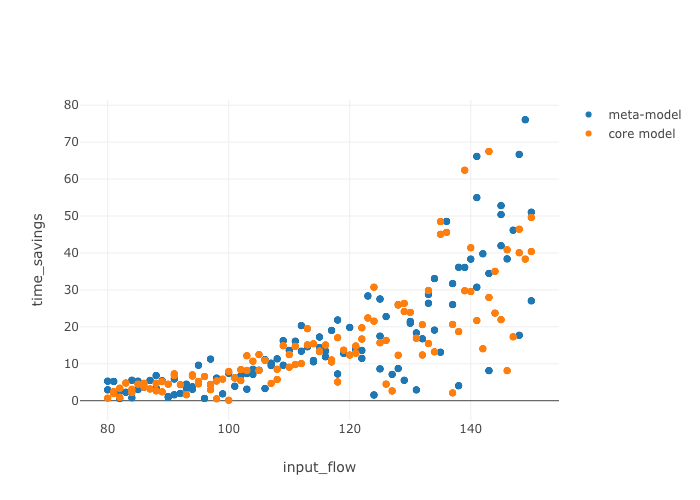

In [43]:
Show(scatter_graph(
    X=[ design2_results['input_flow'],
        lhs_results['input_flow'] ],
    Y=[ design2_results['time_savings'],
        lhs_results['time_savings'],  ],
    legend_labels=[ 'meta-model',
                    'core model',  ]
))

<xmle.Elem 'img' with 0 children>
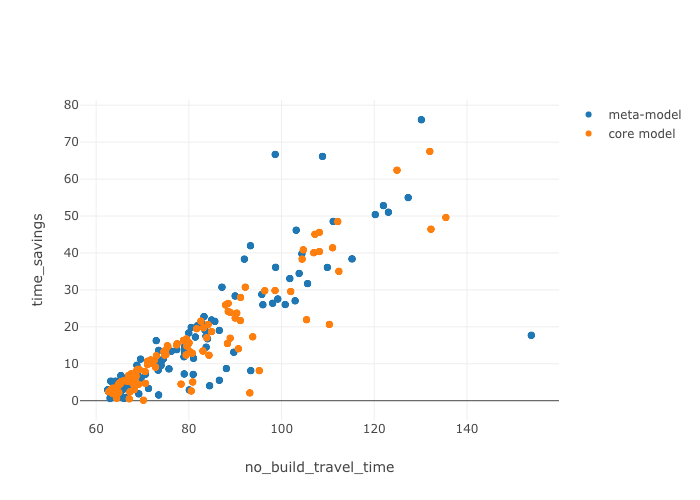

In [44]:
Show(scatter_graph(
    X=[ design2_results['no_build_travel_time'],
        lhs_results['no_build_travel_time'], ],
    Y=[ design2_results['time_savings'],
        lhs_results['time_savings'], ],
    legend_labels=[ 'meta-model',
                    'core model', ]
))

<xmle.Elem 'img' with 0 children>
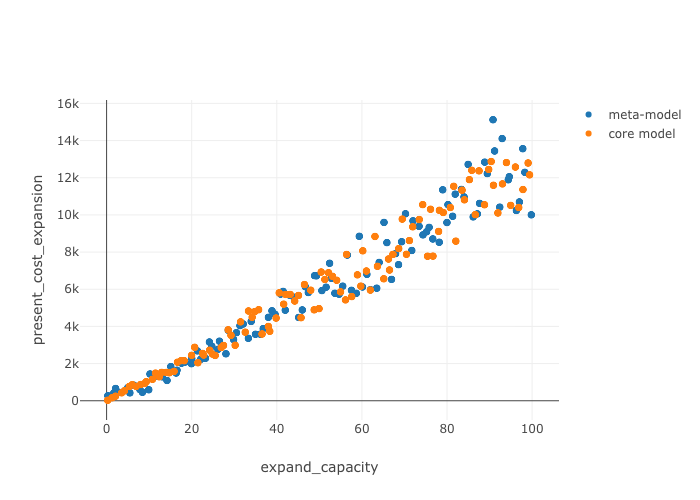

In [45]:
Show(scatter_graph(
    X=[ design2_results['expand_capacity'],
        lhs_results['expand_capacity'], ],
    Y=[ design2_results['present_cost_expansion'],
        lhs_results['present_cost_expansion'], ],
    legend_labels=[ 'meta-model',
                    'core model', ]
))

## Self-Evaluating Meta-Model Performance

In [46]:
background = design_experiments(road_scope, n_samples=1000, sampler='ulhs', db=None, random_seed=42)

In [47]:
measure_std = mm.function.compute_std(background)

In [48]:
measure= mm.function(background)

In [49]:
# measure_std = background.apply(
#     lambda x: pandas.Series(mm.function.compute_std(**x)),
#     axis=1,
# )

In [50]:
background.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
alpha                  1000 non-null float64
amortization_period    1000 non-null int64
beta                   1000 non-null float64
debt_type              1000 non-null object
expand_capacity        1000 non-null float64
input_flow             1000 non-null int64
interest_rate          1000 non-null float64
interest_rate_lock     1000 non-null bool
unit_cost_expansion    1000 non-null float64
value_of_time          1000 non-null float64
yield_curve            1000 non-null float64
free_flow_time         1000 non-null int64
initial_capacity       1000 non-null int64
dtypes: bool(1), float64(7), int64(4), object(1)
memory usage: 94.8+ KB


In [51]:
# background.join(measure_std.add_suffix("_std"))

In [52]:
import seaborn as sns

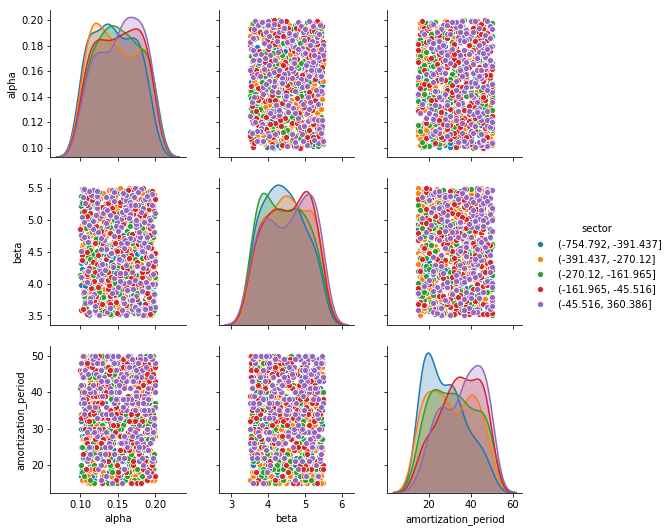

In [53]:
sns.pairplot(
    background.join(pandas.qcut(measure.net_benefits, 5).rename("sector")),
    hue='sector',
    vars=['alpha','beta','amortization_period']
)

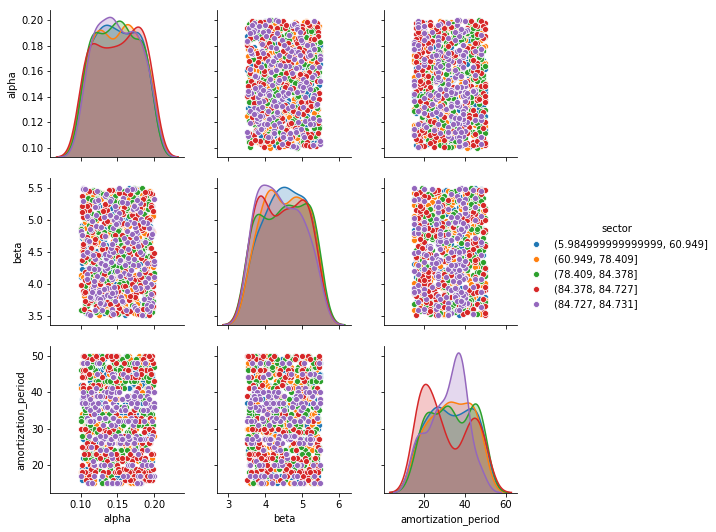

In [54]:
sns.pairplot(
    background.join(measure_std.add_suffix("_std")).join(pandas.qcut(measure_std.net_benefits, 5).rename("sector")),
    hue='sector',
    vars=['alpha','beta','amortization_period']
)

In [55]:
draws = design_experiments(road_scope, n_samples=2000, sampler='lhs', db=None, random_seed=45)

In [56]:
drawx = mm.run_experiments(draws, db=False)

[01:38.73] MainProcess/INFO: performing 2000 scenarios/policies * 1 model(s) = 2000 experiments
[01:38.74] MainProcess/INFO: performing experiments sequentially
[01:40.18] MainProcess/INFO: 200 cases completed
[01:41.53] MainProcess/INFO: 400 cases completed
[01:42.86] MainProcess/INFO: 600 cases completed
[01:44.24] MainProcess/INFO: 800 cases completed
[01:45.64] MainProcess/INFO: 1000 cases completed
[01:46.98] MainProcess/INFO: 1200 cases completed
[01:48.36] MainProcess/INFO: 1400 cases completed
[01:49.71] MainProcess/INFO: 1600 cases completed
[01:51.21] MainProcess/INFO: 1800 cases completed
[01:52.60] MainProcess/INFO: 2000 cases completed
[01:52.60] MainProcess/INFO: experiments finished


In [57]:
drawx_std = mm.function.compute_std(draws)

In [58]:
prim_alg = prim.Prim(
    draws, 
    drawx['net_benefits']>0, 
    threshold=0.4,
)

In [59]:
box1 = prim_alg.find_box()

[02:10.50] MainProcess/INFO: 2000 points remaining, containing 299 cases of interest
[02:12.96] MainProcess/INFO: mean: 0.8543689320388349, mass: 0.0515, coverage: 0.29431438127090304, density: 0.8543689320388349 restricted_dimensions: 6


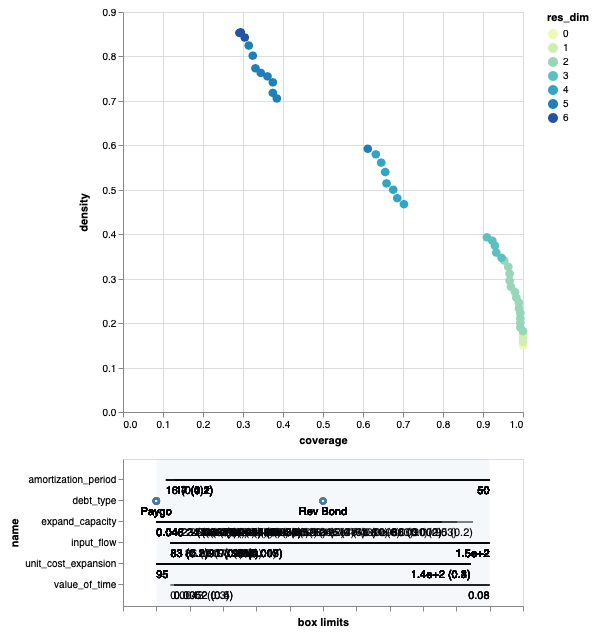

In [60]:
tradeoff = box1.inspect_tradeoff()
tradeoff

In [61]:
n = 31
box1.inspect(n)

coverage    0.384615
density     0.705521
id                31
mass          0.0815
mean        0.705521
res_dim            5
Name: 31, dtype: object

                        box 31                                         
                           min      max                       qp values
expand_capacity      0.0457582  31.5564  [-1.0, 3.3409467365927977e-29]
unit_cost_expansion    95.0085  142.141     [-1.0, 0.32896197374054803]
debt_type              {Paygo}  {Paygo}   [3.328455646432185e-08, -1.0]
input_flow                  91      150     [0.05686185862980676, -1.0]
amortization_period         17       50     [0.13132645467571677, -1.0]



In [62]:
box1.box_lims[n]

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve,free_flow_time,initial_capacity
0,0.100047,17,3.500012,{Paygo},0.045758,91,0.025002,"{False, True}",95.008492,0.001024,-0.002493,60,100
1,0.199981,50,5.499002,{Paygo},31.556414,150,0.039999,"{False, True}",142.141126,0.079965,0.020000,60,100


In [63]:
box1.select(n)

In [64]:
box1.yi

array([  18,   69,   70,   92,   97,  123,  129,  139,  146,  175,  182,
        191,  206,  211,  221,  222,  235,  254,  259,  268,  302,  329,
        335,  354,  381,  391,  419,  423,  425,  426,  435,  438,  439,
        455,  458,  463,  468,  473,  500,  537,  540,  575,  588,  613,
        621,  633,  638,  639,  642,  644,  661,  684,  694,  723,  726,
        732,  733,  739,  757,  767,  779,  785,  791,  809,  811,  824,
        852,  857,  862,  863,  868,  888,  889,  893,  900,  917,  922,
        924,  937,  949,  951,  963,  974,  976,  991, 1007, 1033, 1039,
       1042, 1044, 1045, 1057, 1064, 1093, 1098, 1099, 1102, 1104, 1113,
       1122, 1124, 1138, 1142, 1156, 1185, 1194, 1195, 1200, 1202, 1215,
       1229, 1245, 1246, 1282, 1288, 1290, 1294, 1325, 1329, 1334, 1350,
       1373, 1384, 1452, 1455, 1460, 1475, 1477, 1487, 1498, 1515, 1541,
       1547, 1551, 1568, 1642, 1648, 1649, 1656, 1659, 1665, 1669, 1682,
       1693, 1701, 1729, 1735, 1759, 1765, 1771, 17

In [65]:
drawx_std.drop(box1.yi).net_benefits.mean()

72.9331287030558

In [66]:
drawx_std.iloc[box1.yi].net_benefits.mean()

71.13977900051944

In [67]:
bb = box1.to_emat_box()

In [68]:
bb.scope = road_scope

In [69]:
bb

Box: prim box 31
   coverage: 0.38462
   density:  0.70552
   mass:     0.08150
   ●  amortization_period >= 17
   ●            debt_type: {'Paygo'}
   ●      expand_capacity <= 31.55641402673575
   ●           input_flow >= 91
   ●  unit_cost_expansion <= 142.14112639309877

In [70]:
bb.uncertainty_thresholds

{'input_flow': Bounds(lowerbound=91, upperbound=None),
 'unit_cost_expansion': Bounds(lowerbound=None, upperbound=142.14112639309877)}

In [71]:
bb.lever_thresholds

{'amortization_period': Bounds(lowerbound=17, upperbound=None),
 'debt_type': {'Paygo'},
 'expand_capacity': Bounds(lowerbound=None, upperbound=31.55641402673575)}

In [72]:
draws_bb = design_experiments(bb, n_samples=2000, sampler='lhs', db=None, random_seed=46)

In [77]:
draws_bb

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve,free_flow_time,initial_capacity
0,0.119272,31,5.206758,Paygo,10.656310,119,0.031665,True,138.876025,0.041972,0.000377,60,100
1,0.109899,46,4.355591,Paygo,3.461472,93,0.037661,True,95.700385,0.058564,0.012879,60,100
2,0.115566,43,3.998598,Paygo,8.935932,101,0.027262,True,106.477248,0.027752,0.006887,60,100
3,0.175710,37,5.182282,Paygo,16.459472,132,0.034222,True,133.669064,0.003591,0.012897,60,100
4,0.135804,33,4.027982,Paygo,11.497192,92,0.039470,False,118.634916,0.010117,0.003723,60,100
5,0.162022,29,4.420966,Paygo,31.054659,137,0.038435,False,140.474071,0.050650,0.016162,60,100
6,0.126222,33,4.432840,Paygo,29.489103,123,0.035141,True,113.373490,0.001702,0.008310,60,100
7,0.199404,27,5.411064,Paygo,14.516223,113,0.031536,False,129.676964,0.066836,0.016975,60,100
8,0.118736,45,5.259004,Paygo,5.999057,114,0.030624,False,99.147023,0.079338,0.017848,60,100
9,0.138412,32,5.186705,Paygo,2.684946,131,0.028854,False,104.980278,0.045196,0.004250,60,100


In [ ]:
from emat.util.distributions import truncated, get_distribution_bounds
import copy

In [ ]:
def get_uncertainties(self):
    """Get a list of exogenous uncertainties."""
    result = []
    thresh = self.uncertainty_thresholds
    for i in self.scope.get_uncertainties():
        i = copy.deepcopy(i)
        if i.name in thresh:
            lowerbound, upperbound = thresh[i.name]
            if lowerbound is None:
                lowerbound = -numpy.inf
            if upperbound is None:
                upperbound = numpy.inf
            i.dist = truncated(i.dist, lowerbound, upperbound)
            i.lower_bound, i.upper_bound = get_distribution_bounds(i.dist)
        result.append(i)
    return result


In [ ]:
j = [(i, i.name, i.lower_bound, i.upper_bound) for i in get_uncertainties(bb)]
j

In [ ]:
di = j[2][0].dist

In [ ]:
di.ppf(0)

In [ ]:
di.ppf(1)

In [ ]:
di

In [ ]:
dt.ppf(0), dt.ppf(1)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
x = numpy.linspace(2,7, 1000)
plt.plot(x, di.pdf(x))
plt.plot(x, dt.pdf(x))

In [ ]:
print(road_scope.dump())